# Assignment 6
Collaborative work by Adrian Bremer & Philipp Reinig

# Setup

### Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
tfkl = tf.keras.layers


### Loading the Dataset

In [2]:
# data
# remove infrequent words. you can play with this parameter as it will likely impact model quality
train_data, test_data = tf.keras.datasets.imdb.load_data(num_words=5000)
(train_sequences, train_labels) = train_data
(test_sequences, test_labels) = test_data

### Constants

In [3]:
train_dataset_size = len(train_sequences)
test_dataset_size = len(test_sequences)

max_sequence_length = int(tf.reduce_max([len(train_sequence) for train_sequence in train_sequences]))

# Utils

In [4]:
def print_training_info(epoch, training_loss, training_accuracy, test_loss, test_accuracy):
  print(f"Epoch: {epoch}")
  print(f"\tTraining loss: {training_loss}")
  print(f"\tTraining accuracy: {training_accuracy}")
  print(f"\tTest loss: {test_loss}")
  print(f"\tTest accuracy: {test_accuracy}")
  print("-------------------------------------------------------------")


def truncate_sequences(sequences, length):
  return [sequence[:length] for sequence in sequences]

# Defining Hyperparameters

In [5]:
num_words = 5000

batch_size = 128
epochs = 10
learning_rate = 0.001

hidden_size = 128
use_softmax = False

shall_print_training_info = True

# Implementing various Optimizations

### Reference Model

In [6]:
def model_reference():
  sequence_truncation_length = 200


  # if you wanna see a more low-level one, it's at the bottom of the notebook.
  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=True)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(tf.shape(sequence_batch)[1]):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(new_state)

    return o_t

  @tf.function(jit_compile=True)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss


  # luckily there is a convenient function for padding
  train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=sequence_truncation_length)
  test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=sequence_truncation_length)

  train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels)).shuffle(25000).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels)).batch(batch_size)


  # create model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(1, epochs+1):
      loss_metric.reset_state()
      accuracy_metric.reset_state()
      for sequences, labels in train_dataset:
          batch_loss = train_step(sequences, labels)

      train_losses.append(loss_metric.result())
      train_accs.append(accuracy_metric.result())

      for sequences, labels in test_dataset:
          logits = rnn_loop(sequences)
          accuracy_metric(labels, logits)
          loss_metric(labels, logits)

      test_losses.append(loss_metric.result())
      test_accs.append( accuracy_metric.result())

      if shall_print_training_info:
        print_training_info(epoch, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


### Within-batch Padding

In [7]:
def model_within_batch_padding():
  sequence_truncation_length = 200

  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=True)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(tf.shape(sequence_batch)[1]):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(new_state)

    return o_t

  @tf.function(jit_compile=True)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss

  # Create Model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)


  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(epochs):
      loss_metric.reset_state()
      accuracy_metric.reset_state()

      for i in range(0, train_dataset_size // batch_size):
        train_sequences_batch = train_sequences[i * batch_size : min((i+1)*batch_size, train_dataset_size)]
        train_sequences_batch_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences_batch, maxlen=sequence_truncation_length, padding="pre")
        train_labels_batch = train_labels[i * batch_size : min((i+1)*batch_size, train_dataset_size)]

        batch_loss = train_step(tf.constant(train_sequences_batch_padded), tf.constant(train_labels_batch))

      train_losses.append(loss_metric.result())
      train_accs.append( accuracy_metric.result())

      for i in range(0, test_dataset_size // batch_size):
        test_sequences_batch = test_sequences[i * batch_size : min((i+1)*batch_size, test_dataset_size)]
        test_sequences_batch_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_batch, maxlen=sequence_truncation_length, padding="pre")
        test_labels_batch = test_labels[i * batch_size : min((i+1)*batch_size, test_dataset_size)]

        logits = rnn_loop(tf.constant(test_sequences_batch_padded))
        accuracy_metric(test_labels_batch, logits)
        loss_metric(test_labels_batch, logits)

      test_losses.append(loss_metric.result())
      test_accs.append(accuracy_metric.result())


      if print_training_info:
        print_training_info(epoch+1, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


## Bucketing

In [66]:
def model_bucketing():
  sequence_truncation_length = 500
  bucket_amt = 10


  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=False)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(tf.shape(sequence_batch)[1]):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(new_state)

    return o_t

  @tf.function(jit_compile=False)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss

  def bucket_dataset(dataset, bucket_amount, max_length): #max_length is the length of the longest occuring sequence in the dataset
    if (len(dataset[0]) != len(dataset[1])):
      raise ValueError

    bucket_width = max_length // bucket_amount
    bucketed_sequences = [[] for _ in range(bucket_amount)]
    bucketed_labels = [[] for _ in range(bucket_amount)]
    for i in range(len(dataset[0])):
      train_sequence = dataset[0][i]
      train_label = dataset[1][i]
      bucket_indx = (len(train_sequence)-1) // bucket_width
      bucketed_sequences[bucket_indx].append(train_sequence)
      bucketed_labels[bucket_indx].append(train_label)

    return bucketed_sequences, bucketed_labels


  truncated_train_sequences = truncate_sequences(train_sequences, sequence_truncation_length)
  bucketed_train_sequences, bucketed_train_labels = bucket_dataset((truncated_train_sequences, train_labels), bucket_amt, sequence_truncation_length)

  truncated_test_sequences = truncate_sequences(test_sequences, sequence_truncation_length)
  bucketed_test_sequences, bucketed_test_labels = bucket_dataset((truncated_test_sequences, train_labels), bucket_amt, sequence_truncation_length)

  # create model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(1, epochs+1):
      loss_metric.reset_state()
      accuracy_metric.reset_state()

      for train_sequences_bucket, train_labels_bucket in zip(bucketed_train_sequences, bucketed_train_labels):
        bucket_size = len(train_sequences_bucket)

        for i in range(0, max(bucket_size // batch_size, 1)):
          train_sequences_batch = train_sequences_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          max_sequence_length_in_batch = int(tf.reduce_max([len(seq) for seq in train_sequences_batch]))

          train_sequences_padded_batch = tf.keras.preprocessing.sequence.pad_sequences(train_sequences_batch, maxlen=max_sequence_length_in_batch, padding="pre")
          train_labels_batch = train_labels_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          train_sequences_padded_batch_tensor = tf.constant(train_sequences_padded_batch)

          batch_loss = train_step(train_sequences_padded_batch_tensor, tf.constant(train_labels_batch))


      train_losses.append(loss_metric.result())
      train_accs.append(accuracy_metric.result())

      for test_sequences_bucket, test_labels_bucket in zip(bucketed_test_sequences, bucketed_test_labels):
        bucket_size = len(test_sequences_bucket)

        for i in range(0, max(bucket_size // batch_size, 1)):
          test_sequences_batch = test_sequences_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          max_sequence_length_in_batch = int(tf.reduce_max([len(seq) for seq in test_sequences_batch]))

          test_sequences_padded_batch = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_batch, maxlen=max_sequence_length_in_batch, padding="pre")
          test_labels_batch = test_labels_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          test_labels_batch_tensor = tf.constant(test_labels_batch)

          logits = rnn_loop(tf.constant(test_sequences_padded_batch))
          accuracy_metric(test_labels_batch_tensor, logits)
          loss_metric(test_labels_batch_tensor, logits)

      test_losses.append(loss_metric.result())
      test_accs.append(accuracy_metric.result())


      if print_training_info:
        print_training_info(epoch, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


# Training the different Models/Optimizations

In [9]:
training_results = {}

### Reference Model

In [10]:
training_results["Reference"] =  model_reference()

Epoch: 1
	Training loss: 0.9501785039901733
	Training accuracy: 0.5450000166893005
	Test loss: 0.7713249921798706
	Test accuracy: 0.5616199970245361
-------------------------------------------------------------
Epoch: 2
	Training loss: 0.8693112730979919
	Training accuracy: 0.6456800103187561
	Test loss: 0.7547914385795593
	Test accuracy: 0.6528599858283997
-------------------------------------------------------------
Epoch: 3
	Training loss: 0.7235770225524902
	Training accuracy: 0.7264000177383423
	Test loss: 0.7258052229881287
	Test accuracy: 0.7231000065803528
-------------------------------------------------------------
Epoch: 4
	Training loss: 0.825154185295105
	Training accuracy: 0.7408000230789185
	Test loss: 0.810326874256134
	Test accuracy: 0.6848599910736084
-------------------------------------------------------------
Epoch: 5
	Training loss: 0.6613508462905884
	Training accuracy: 0.7859600186347961
	Test loss: 0.7868991494178772
	Test accuracy: 0.760420024394989
----------

### Within-Batch Padding

In [11]:
training_results["Within-Batch Padding"] =  model_within_batch_padding()

tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), dtype=int32)
tf.Tensor([128 200], shape=(2,), d

### Bucketing

In [67]:
training_results["Bucketing"] = model_bucketing()

Epoch: 1
	Training loss: 1.0202423334121704
	Training accuracy: 0.5450032353401184
	Test loss: 1.057705283164978
	Test accuracy: 0.5223944783210754
-------------------------------------------------------------
Epoch: 2
	Training loss: 0.8235738277435303
	Training accuracy: 0.6504719853401184
	Test loss: 1.8077781200408936
	Test accuracy: 0.574198305606842
-------------------------------------------------------------
Epoch: 3
	Training loss: 0.8912684321403503
	Training accuracy: 0.6880289912223816
	Test loss: 1.42709481716156
	Test accuracy: 0.5936886668205261
-------------------------------------------------------------
Epoch: 4
	Training loss: 0.7731756567955017
	Training accuracy: 0.750732421875
	Test loss: 1.792391300201416
	Test accuracy: 0.625286340713501
-------------------------------------------------------------
Epoch: 5
	Training loss: 0.8880788683891296
	Training accuracy: 0.7908935546875
	Test loss: 2.191258192062378
	Test accuracy: 0.6443063020706177
---------------------

# Analysis

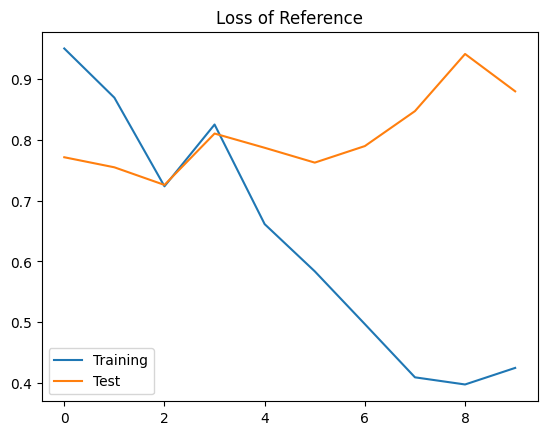

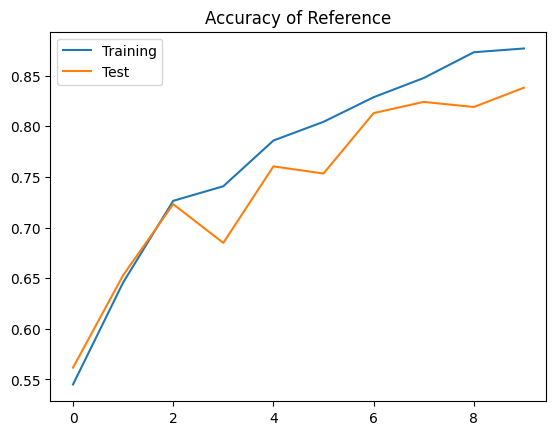

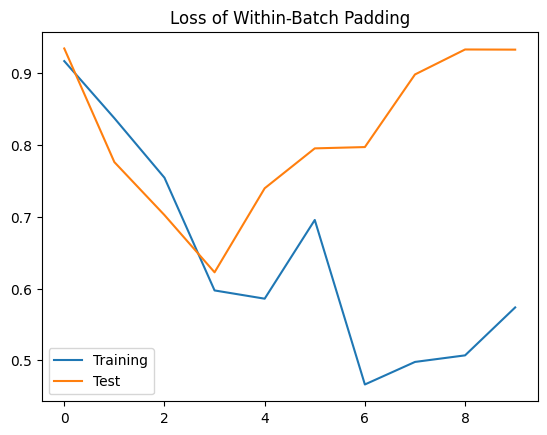

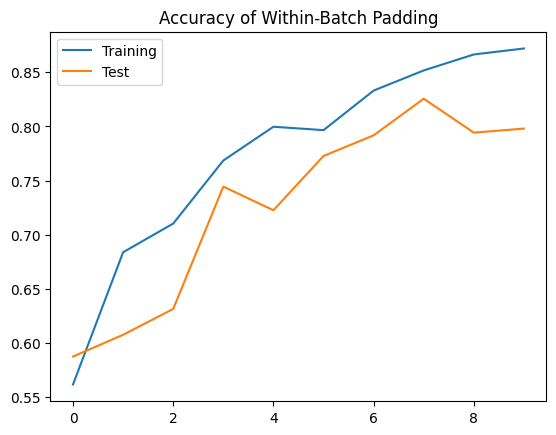

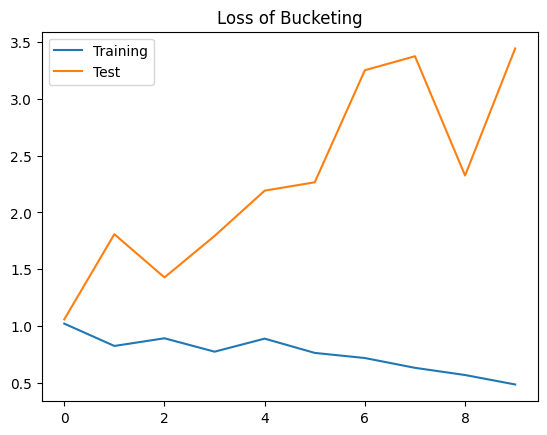

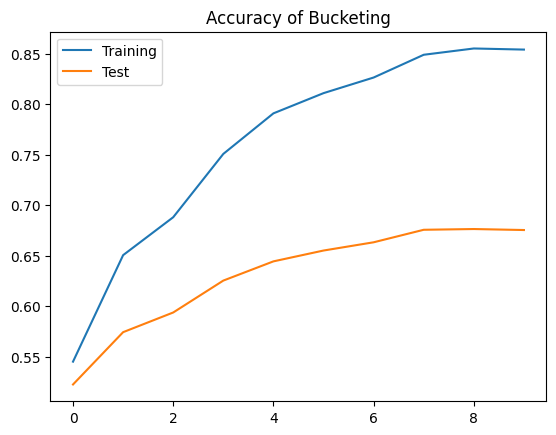

In [68]:
for key, (train_losses, train_accs, test_losses, test_accs) in training_results.items():
  plt.plot(train_losses, label="Training")
  plt.plot(test_losses, label="Test")
  plt.title(f"Loss of {key}")
  plt.legend()
  plt.show()

  plt.plot(train_accs, label="Training")
  plt.plot(test_accs, label="Test")
  plt.title(f"Accuracy of {key}")
  plt.legend()
  plt.show()

# Results
Quick summary: Performance around 10% worse per "optimization" and training time increased, too. We didn't measure it, but it was significantly noticable.

Interesting: Trend/behaviour of loss and accuracy are similiar over the 10 epochs for all versions.

# Archive

In [69]:
# to restore words, load the word-to-index mapping
word_to_index = tf.keras.datasets.imdb.get_word_index()
# invert to get index-to-word mapping
index_to_word = dict((index, word) for (word, index) in word_to_index.items())

1641221/1641221 [==============================] - 0s 0us/step


In [70]:
# here we check the output over time for single sequences, as shown in the exercise.

test_index = 4
# NOTE technically we need to use test_sequences_padded here! Results will be quite different!
test_sequence = test_sequences[test_index]

print("sequence for testing:")
print(" ".join([index_to_word.get(index -  3, "UNKNOWN") for index in test_sequence[1:]]))
print("\nTrue label: ", test_labels[test_index])

sequence for testing:
like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and UNKNOWN they will hook you UNKNOWN your mind turns to UNKNOWN i'm not kidding this game is also UNKNOWN and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good UNKNOWN 10 attention UNKNOWN 10 average 10

True label:  1


In [72]:
plt.figure(figsize=(15, 5))
plt.plot(rnn_output)
plt.plot(rnn_output, "b*")

ticks = np.arange(0, len(test_sequence), 1)
plt.xticks(ticks=ticks, labels=[index_to_word.get(test_sequence[ind]-3, 'UNK') for ind in ticks],
               rotation="vertical")
plt.ylim(0, 1)
plt.plot(0.5*np.ones(len(rnn_output)), "--")
plt.ylabel('probability output')
plt.show()

NameError: ignored

<Figure size 1500x500 with 0 Axes>

In [ ]:
# NOTE a simpler/more straightforward way to implement the RNN would be something like this.
# but note that this initializes weights with standard deviation = 1!
# This will be way too much and most likely lead to exploding gradients!

# in general, RNNs are very sensitive to initialization.
# using Keras layers with the automatically scaled initializers can be a good idea.
"""
w_x_h = tf.Variable(tf.random.normal((num_words, hidden_size)))
w_h_h = tf.Variable(tf.random.normal((hidden_size, hidden_size)))
b_h = tf.Variable(tf.zeros(hidden_size))

w_h_o = tf.Variable(tf.random.normal((hidden_size, 1)))
b_o = tf.Variable(tf.zeros(1))


@tf.function
def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(max_len):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        new_state = tf.nn.tanh(tf.matmul(x_t, w_x_h) + tf.matmul(old_state, w_h_h) + b_h)

        old_state = new_state

    o_t = tf.matmul(new_state, w_h_o) + b_o
    tf.matmul(w_h_o, new_state)

    return o_t
"""